In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from matplotlib_venn import venn2 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

In [ ]:
# Linear models
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    SGDClassifier,
    Perceptron,
    PassiveAggressiveClassifier
)

# Trees
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

# Ensembles
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier
)

# SVM
from sklearn.svm import SVC, NuSVC, LinearSVC

# KNN
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

# Neural network
from sklearn.neural_network import MLPClassifier

# Naive Bayes
from sklearn.naive_bayes import (
    GaussianNB,
    MultinomialNB,
    BernoulliNB,
    ComplementNB
)

# Discriminant Analysis
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis
)

# Gaussian Process
from sklearn.gaussian_process import GaussianProcessClassifier

### Comparison MS data v1

In [ ]:
dataset1 = "deybis_05" # "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
dataset2 = "vanessa_05" # "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset

encoder = "GIN"

In [ ]:
list_train_set = [
	["FrescoAmazonas_1", "FrescoAmazonas_2"],
	["FrescoCusco_1", "FrescoCusco_2"],
	["FrescoSanMartin_1", "FrescoSanMartin_2"],
	["SecoAmazonas_1", "SecoAmazonas_2"],
	["SecoCusco_1", "SecoCusco_2"],
	["SecoSanMartin_1", "SecoSanMartin_2"]
]

In [ ]:
tol_rt, tol_mz = 0.5, 15 # 0.5 min, 10 ppm

for train_set in list_train_set:
	df_1 = pd.read_csv(f"data/{dataset1}/output/node_alignment_{encoder}_{dataset1}_{train_set}.csv" , sep=";", decimal=",")
	df_2 = pd.read_csv(f"data/{dataset2}/output/node_alignment_{encoder}_{dataset2}_{train_set}.csv" , sep=";", decimal=",")

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	df_match["mz_error"] = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() /
		((df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
	) * 1e6

	df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	df_match

	df_match_filter = df_match[df_match["mz_error"] < tol_mz]
	# df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
	
	print(train_set)
	display(df_match_filter)

In [ ]:
tol_rt, tol_mz = 0.5, 15 # 0.5 min, 10 ppm

df_1 = pd.read_csv(f"data/{dataset1}/raw.csv", index_col=0).iloc[:, :3] # Sep
df_2 = pd.read_csv(f"data/{dataset2}/raw.csv", index_col=0).iloc[:, :3] # Dec
print(len(df_1), len(df_2))

df_match = (
	df_1.assign(key=1)
		.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
		.drop(columns="key")
)

df_match["mz_error"] = (
	(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() /
	((df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
) * 1e6

df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
df_match

In [ ]:
df_match_filter = df_match[df_match["mz_error"] < tol_mz]
df_match_filter

In [ ]:
df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
df_match_filter

In [ ]:
""" rt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
mz_diff = (
	((df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() / (df_match["Average Mz_1"] + df_match["Average Mz_2"]) / 2)
) * 1e6
mask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)
# mask = (mz_diff <= tol_mz)

df_intersection = df_match.loc[mask].reset_index(drop=True)
df_intersection """

In [ ]:
""" tol_rt, tol_mz = 0.5, 0.01 # Change

for train_set in list_train_set:
	df_1 = pd.read_csv(f"data/{dataset1}/output/node_alignment_{encoder}_{dataset1}_{train_set}.csv" , sep=";", decimal=",")
	df_2 = pd.read_csv(f"data/{dataset2}/output/node_alignment_{encoder}_{dataset2}_{train_set}.csv" , sep=";", decimal=",")

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	rt_diff = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	mz_diff = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs() # / df_match["Average Mz_2"] * 1e6
	)
	# mask = (rt_diff <= tol_rt) & (mz_diff <= tol_mz)
	mask = (mz_diff <= tol_mz)

	df_intersection = df_match.loc[mask].reset_index(drop=True)
	print(train_set)
	display(df_intersection) """

### Comparison filter Deybis

In [ ]:
dataset1 = "deybis_filter_september_2br_10ar" # "deybis_filter_september_05", "deybis_filter_december_05", "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
dataset2 = "deybis_filter_december_2br_10ar" # "deybis_filter_september_05", "deybis_filter_december_05",

# Parameters data
file = open(f"data/{dataset1}/input/parameters.json")
params = json.load(file)

methods = params["methods"]
print("Methods:\t", methods)

data_variations = params["data_variations"]
print("Data variations:", data_variations)

has_transformation = params["has_transformation"]
print("Has transformation:", has_transformation)

dimension = params["dimension"]
print("Dimension:\t", dimension)

threshold_corr = params["threshold_corr"]
print("Threshold corr:\t", threshold_corr)

iterations = params["iterations"]
print("Iterations:\t", iterations)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

groups_id_no = params["groups_id_no"]
print("Groups id (no):\t", groups_id_no)

seeds = params["seeds"]
print("Seeds:\t\t", seeds)

sensitivity = params["sensitivity"]
print("Sensitivity:\t", sensitivity)

In [ ]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/input/raw.csv".format(dataset1), index_col=0)
df_join_raw

In [ ]:
# Filter

list_node_intersection = []
for group_id in groups_id:
	print(group_id)

	# Read common node
	common_node_id1 = sorted(np.load(f"data/{dataset1}/output/common_node/{group_id}.npy"))
	common_node_id2 = sorted(np.load(f"data/{dataset2}/output/common_node/{group_id}.npy"))
	# print(common_node_id1)
	# print(common_node_id2)

	intersection = sorted(list(set(common_node_id1) & set(common_node_id2)))
	# print(intersection)
	
	list_node_intersection.append([group_id, intersection])
	# list_node_intersection.append([group_id, ",".join(map(str, intersection))])

	# Plot
	plt.figure()
	venn2(subsets=(len(common_node_id1), len(common_node_id2), len(intersection)), set_labels=("September", "December"))
	plt.show()

df_comparison = pd.DataFrame(list_node_intersection, columns=["Group id", "Common node id"])
df_comparison

In [ ]:
# Filter by gropu id

for i, group_id in enumerate(groups_id):
	print(group_id)
	common_node_id = list_node_intersection[i][1]
	print(len(common_node_id), common_node_id)

	# Filter raw data
	df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
	# df_join_raw_filter.to_csv(f"data/{dataset}/output/filter_raw/{group_id}.csv", sep=";", decimal=",", index_label="Id")
	display(df_join_raw_filter)

In [ ]:
# Comparison with Statistics

df_sta = pd.read_csv(f"data/deybis_filter_september_2br_3ar/input/sta.csv") # Prof. Alfredo
df_sta

In [ ]:
# Filter by gropu id (using intersection nodes)

tol_rt, tol_mz = 0.5, 0.01
for i, group_id in enumerate(groups_id):
	print(group_id)
	common_node_id = list_node_intersection[i][1]
	print(common_node_id)

	# Filter raw data
	df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1]]

	df_1 = df_sta.copy()
	df_2 = df_join_raw_filter.copy()
	print(len(df_1), len(df_2))

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	df_match["mz_error"] = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs()
	)

	df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	# df_match_filter = df_match[df_match["mz_error"] < tol_mz]
	df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
	display(df_match_filter)

In [ ]:
# Filter by gropu id (using common nodes)

dataset = dataset2 # Change, dataset1, dataset2
tol_rt, tol_mz = 0.5, 0.01
print(dataset)

for i, group_id in enumerate(groups_id):
	print(group_id)
	common_node_id = sorted(np.load(f"data/{dataset}/output/common_node/{group_id}.npy"))
	print(common_node_id)

	# Filter raw data
	df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1]]

	df_1 = df_sta.copy()
	df_2 = df_join_raw_filter.copy()
	print(len(df_1), len(df_2))

	df_match = (
		df_1.assign(key=1)
			.merge(df_2.assign(key=1), on="key", suffixes=("_1", "_2"))
			.drop(columns="key")
	)

	df_match["mz_error"] = (
		(df_match["Average Mz_1"] - df_match["Average Mz_2"]).abs()
	)

	df_match["rt_error"] = (df_match["Average Rt_1"] - df_match["Average Rt_2"]).abs()
	# df_match_filter = df_match[df_match["mz_error"] < tol_mz]
	df_match_filter = df_match[(df_match["mz_error"] < tol_mz) & (df_match["rt_error"] < tol_rt)]
	display(df_match_filter)

### Classification

In [ ]:
# file = open("exp.json")
# experiment = json.load(file)
exp = "exp1" # experiment["exp"] # Change to static

file = open("experiments/output/{}/parameters.json".format(exp))
params = json.load(file)

print("Exp:\t\t", exp)

raw_data_file = params["raw_data_file"]
print("Raw data:\t", raw_data_file)

methods = params["methods"]
print("Methods:\t", methods)

has_transformation = params["has_transformation"]
print("Has transformation:", has_transformation)

dimension = params["dimension"]
print("Dimension:\t", dimension)

groups_id = params["groups_id"]
print("Groups id:\t", groups_id)

subgroups_id = params["subgroups_id"]
print("Subgroups id:\t", subgroups_id)

cuda = params["cuda"]
print("Cuda:\t", cuda)

In [ ]:
# df_join_raw = pd.read_csv(f"experiments/input/{exp}_raw.csv", index_col=0)
df_raw = pd.read_csv(f"experiments/raw_data/deybis_filter_september_all_format.csv", delimiter="|")
df_raw

In [ ]:
# Concat
df_join_raw = pd.concat([df_raw.iloc[:, :]], axis=1)
df_join_raw.set_index("Alignment ID", inplace=True)
df_join_raw = df_join_raw.rename_axis(None)
df_join_raw

In [ ]:
models = {
    # Linear models
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000),
    "RidgeClassifier": RidgeClassifier(random_state=42),
    "SGDClassifier": SGDClassifier(random_state=42),
    "Perceptron": Perceptron(random_state=42),
    "PassiveAggressive": PassiveAggressiveClassifier(random_state=42),

    # Trees
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "ExtraTree": ExtraTreeClassifier(random_state=42),

    # Ensembles
    "RandomForest": RandomForestClassifier(random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "Bagging": BaggingClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "HistGradientBoosting": HistGradientBoostingClassifier(random_state=42),

    # SVM
    "SVC": SVC(random_state=42),
    "NuSVC": NuSVC(random_state=42),
    "LinearSVC": LinearSVC(random_state=42),

    # KNN (no random_state parameter)
    "KNeighbors": KNeighborsClassifier(),
    "RadiusNeighbors": RadiusNeighborsClassifier(),

    # Neural network
    "MLPClassifier": MLPClassifier(random_state=42, max_iter=1000),

    # Naive Bayes (no random_state parameter)
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),

    # Discriminant analysis (no random_state)
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),

    # Gaussian Process (random_state available)
    "GaussianProcess": GaussianProcessClassifier(random_state=42)
}


In [ ]:
# Classification

print(raw_data_file)
list_metrics = []
for name, model in models.items():
    for group_id in groups_id + ["Intersection", "Union"]:
        try:
            # Read common node
            common_node_id = np.load(f"experiments/output/{exp}/common_nodes/{group_id}.npy")
            print(name, group_id, len(common_node_id))
            
            df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:]
            df_join_raw_signal_t = df_join_raw_signal.T
            # display(df_join_raw_signal_t)
            
            # Features
            X = df_join_raw_signal_t.values
            # print(X.shape)

            # Target
            y = df_join_raw_signal_t.index
            y = [item.split("_")[0] for item in y]
            # print(y)
                    
            # Split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            # print(y_test)
            
            # Scaling
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)  # fit only on train
            X_test = scaler.transform(X_test)        # only transform on test
            
            # Select and train model
            model.fit(X_train, y_train)

            # Evaluation
            y_pred = model.predict(X_test)

            accuracy = accuracy_score(y_test, y_pred)
            recall_macro = recall_score(y_test, y_pred, average="macro")
            f1_macro = f1_score(y_test, y_pred, average="macro")
            # classification_rep = classification_report(y_test, y_pred, output_dict=True)
            
            cm = confusion_matrix(y_test, y_pred)
            class_names = model.classes_
            tick_marks = np.arange(len(class_names))
            
            """ plt.figure()
            plt.imshow(cm, cmap="Blues")
            plt.title("Confusion Matrix")
            # plt.colorbar()
            plt.xticks(tick_marks, class_names, rotation=45, ha="right", rotation_mode="anchor")
            plt.yticks(tick_marks, class_names)

            # Values inside each cell
            for i in range(cm.shape[0]):
                for j in range(cm.shape[1]):
                    plt.text(
                        j, i,
                        format(cm[i, j], "d"),
                        ha="center",
                        va="center"
                    )

            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.tight_layout()
            plt.show() """

            # Convert the dictionary to a pandas DataFrame and transpose it
            # df_report = pd.DataFrame(classification_rep).transpose()
            # display(df_report)
            list_metrics.append([name, group_id, len(common_node_id), accuracy, recall_macro, f1_macro])
        except:
            print(f"Error in {name} - {group_id}")

df_metrics = pd.DataFrame(list_metrics,  columns=["Model", "Group id", "Num. common node", "Accuracy", "Recall", "F1-score"])
df_metrics

In [ ]:
df_metrics.sort_values(by="Accuracy", ascending=False).head(50)

#### Select best model

In [ ]:
models

In [51]:
# Select best model (dataset and group id)

exp = "exp1" # Change
group_id = "FrescoCusco" # Change, Union, FrescoCusco

file = open("experiments/output/{}/parameters.json".format(exp))
params = json.load(file)

print("Exp:\t\t", exp)

raw_data_file = params["raw_data_file"]
print("Raw data:\t", raw_data_file)

models_best = models # Change, models_best
# models_best = {"RandomForest": RandomForestClassifier(random_state=42),} # {"ExtraTrees": ExtraTreesClassifier()}

Exp:		 exp1
Raw data:	 deybis_filter_september_2br_3ar_format


FrescoCusco 110


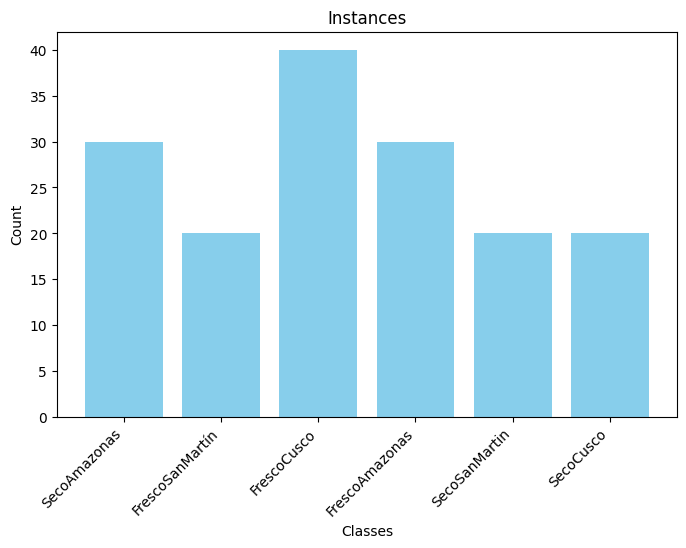

In [52]:
# September data

# Read common node
common_node_id = np.load(f"experiments/output/{exp}/common_nodes/{group_id}.npy")
print(group_id, len(common_node_id))

# df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:] # With common node
df_join_raw_signal = df_join_raw.iloc[:, 3:] # Without common node
df_join_raw_signal_t = df_join_raw_signal.T
# display(df_join_raw_signal_t)

# Features
X = df_join_raw_signal_t.values

# Target
y = df_join_raw_signal_t.index
y = [item.split("_")[0] for item in y]

# Count the occurrences of each item

counts = Counter(y)

# Extract labels (items) and heights (counts) for the plot
labels = list(counts.keys())
values = list(counts.values())

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color="skyblue")

plt.xticks(labels, labels, rotation=45, ha="right")
# Add labels and title
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Instances")

# Display the plot
plt.show()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # fit only on train
X_test = scaler.transform(X_test)        # only transform on test

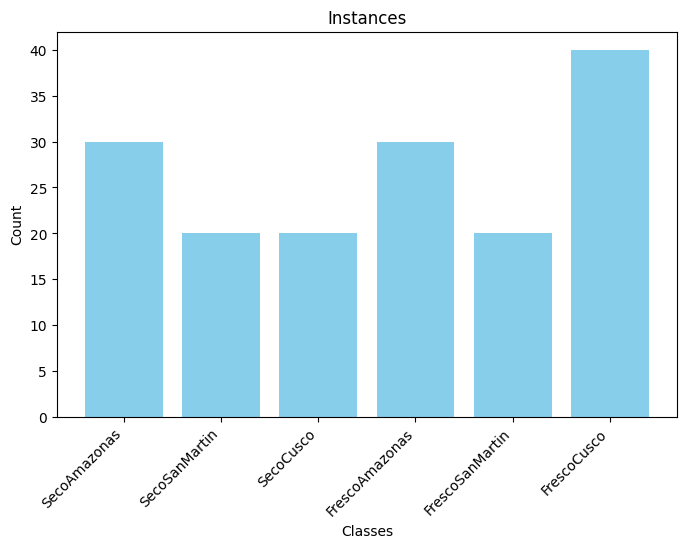

In [53]:
# December data

# Evaluation with December data
# df_join_raw = pd.read_csv(f"experiments/input/{exp}_raw.csv", index_col=0)
df_raw_new = pd.read_csv(f"experiments/raw_data/deybis_filter_december_all_format.csv", delimiter="|")

# Concat
df_join_raw_new = pd.concat([df_raw_new.iloc[:, :]], axis=1)
df_join_raw_new.set_index("Alignment ID", inplace=True)
df_join_raw_new = df_join_raw_new.rename_axis(None)
df_join_raw_new

# df_join_raw_signal_new = df_join_raw_new.loc[common_node_id].iloc[:, 3:] # With common node
df_join_raw_signal_new = df_join_raw_new.iloc[:, 3:] # Without common node

df_join_raw_signal_t_new = df_join_raw_signal_new.T
# display(df_join_raw_signal_t_)

# Features
X_new = df_join_raw_signal_t_new.values

# Target
y_new = df_join_raw_signal_t_new.index
y_new = [item.split("_")[0] for item in y_new]

# Count the occurrences of each item
counts = Counter(y_new)

# Extract labels (items) and heights (counts) for the plot
labels = list(counts.keys())
values = list(counts.values())

# Create the bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color="skyblue")

plt.xticks(labels, labels, rotation=45, ha="right")
# Add labels and title
plt.xlabel("Classes")
plt.ylabel("Count")
plt.title("Instances")

# Display the plot
plt.show()

# Split
# X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size=0.1, random_state=42)

# Scaling
scaler = StandardScaler()
""" X_train_new = scaler.fit_transform(X_train_new)  # fit only on train
X_test_new = scaler.transform(X_test_new)        # only transform on test """

X_test_new = scaler.fit_transform(X_new)        # only transform on test
y_test_new = y_new

Train
Model: LogisticRegression
Accuracy: 1.0
Recall: 1.0
F1-score: 1.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


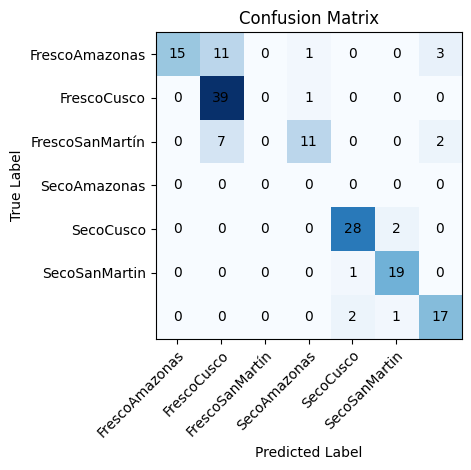

Train
Model: RidgeClassifier
Accuracy: 1.0
Recall: 1.0
F1-score: 1.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


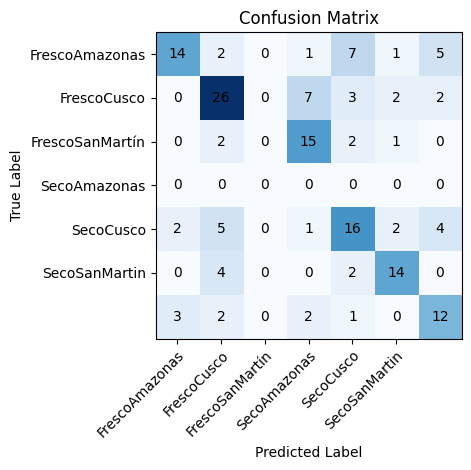

Train
Model: SGDClassifier
Accuracy: 0.9375
Recall: 0.9333333333333332
F1-score: 0.9305555555555557


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


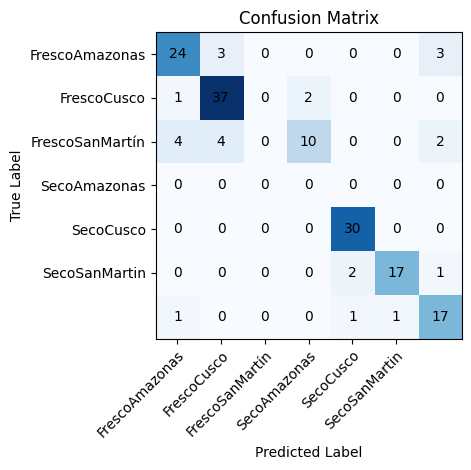

Train
Model: Perceptron
Accuracy: 1.0
Recall: 1.0
F1-score: 1.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


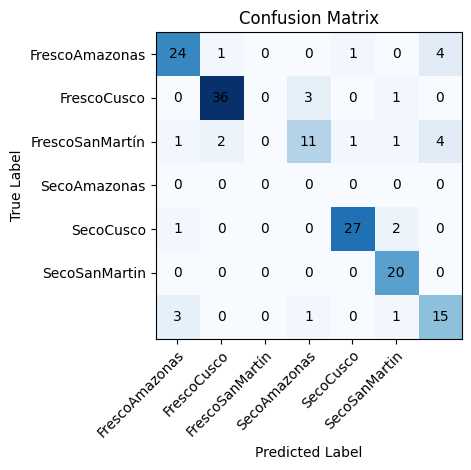

Train
Model: PassiveAggressive
Accuracy: 1.0
Recall: 1.0
F1-score: 1.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


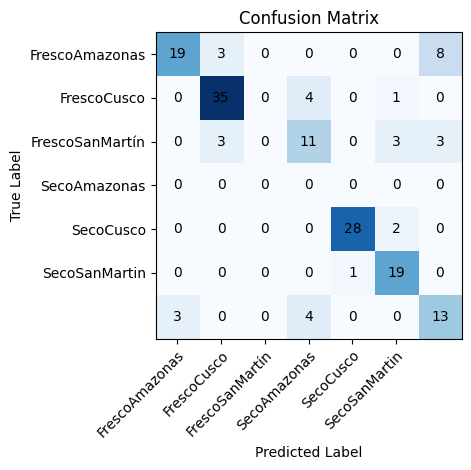

Train
Model: DecisionTree
Accuracy: 0.71875
Recall: 0.7571428571428571
F1-score: 0.7660714285714286


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


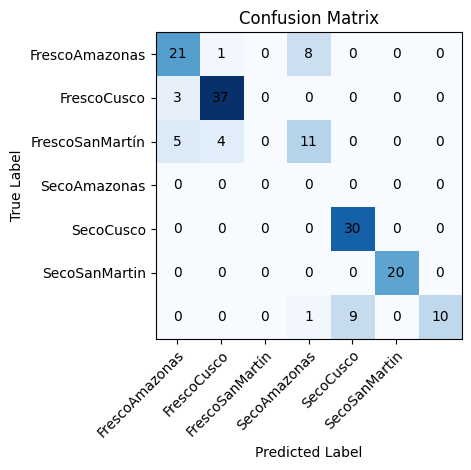

Train
Model: ExtraTree
Accuracy: 0.65625
Recall: 0.6777777777777777
F1-score: 0.6687562437562438


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


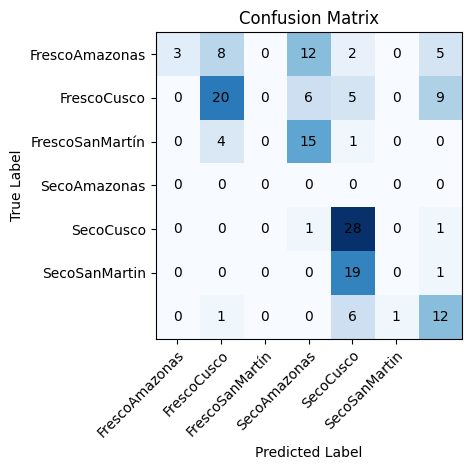

Train
Model: RandomForest
Accuracy: 0.90625
Recall: 0.9285714285714285
F1-score: 0.9225774225774227


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


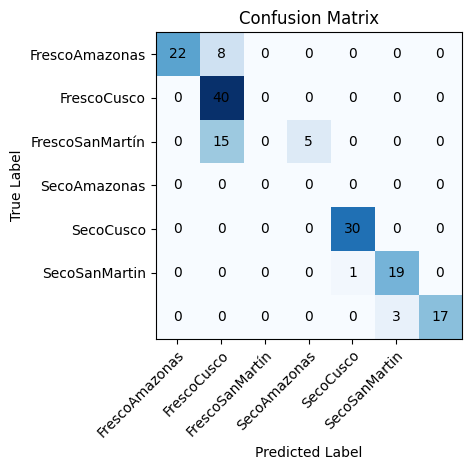

Train
Model: ExtraTrees
Accuracy: 0.90625
Recall: 0.9095238095238095
F1-score: 0.9025835275835276


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


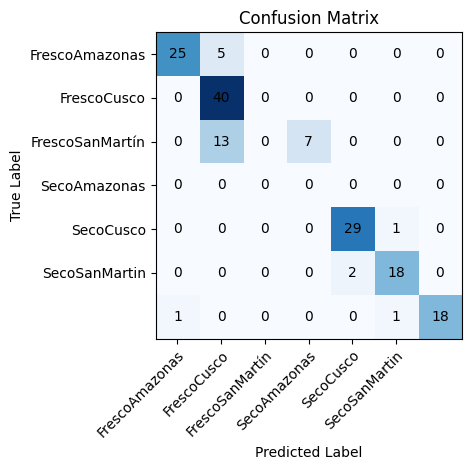

Train
Model: Bagging
Accuracy: 0.71875
Recall: 0.7571428571428571
F1-score: 0.7459045584045585


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


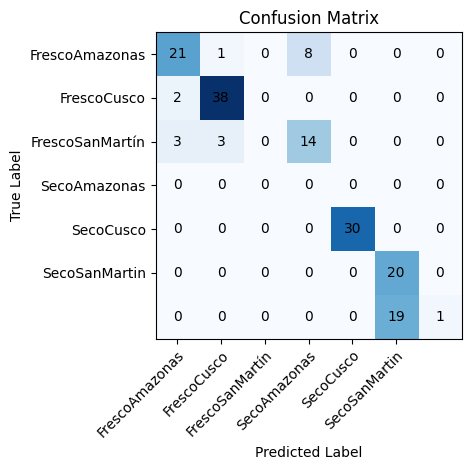

/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Train
Model: AdaBoost
Accuracy: 0.375
Recall: 0.3333333333333333
F1-score: 0.18233618233618235


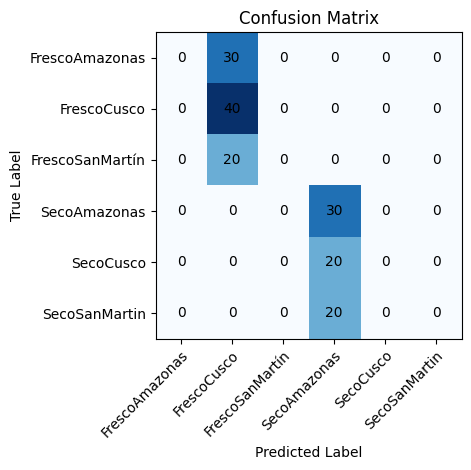

Train
Model: GradientBoosting
Accuracy: 0.75
Recall: 0.7809523809523808
F1-score: 0.7925084175084175


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


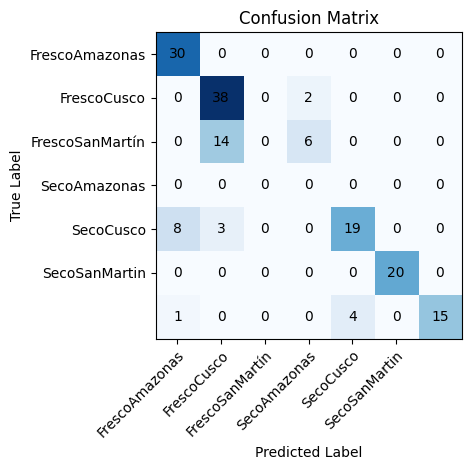

Train
Model: HistGradientBoosting
Accuracy: 0.9375
Recall: 0.942857142857143
F1-score: 0.9337403337403337


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


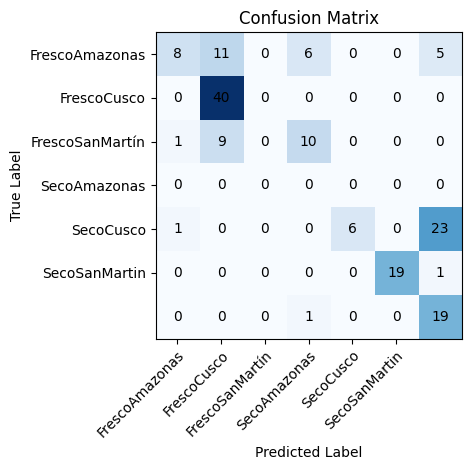

Train
Model: SVC
Accuracy: 0.625
Recall: 0.6349206349206349
F1-score: 0.5495014245014245


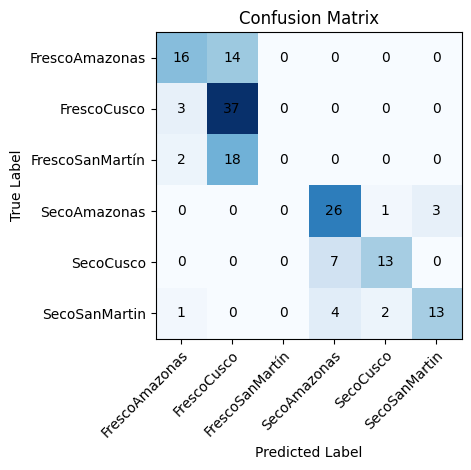

Train
Model: NuSVC
Accuracy: 0.78125
Recall: 0.7857142857142857
F1-score: 0.7259962259962259


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


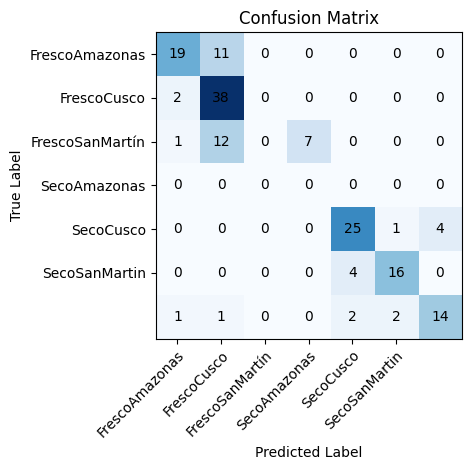

Train
Model: LinearSVC
Accuracy: 1.0
Recall: 1.0
F1-score: 1.0


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


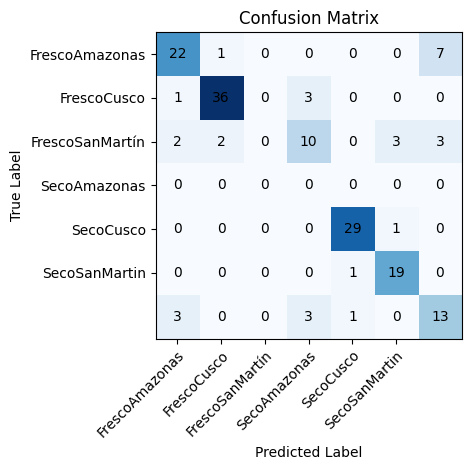

Train
Model: KNeighbors
Accuracy: 0.6875
Recall: 0.6920634920634919
F1-score: 0.6552188552188553


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


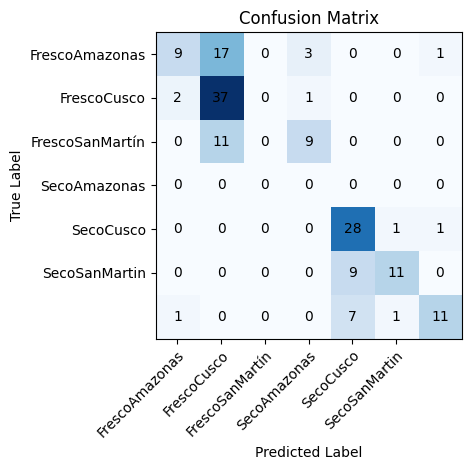

Train
Model: MLPClassifier
Accuracy: 0.84375
Recall: 0.8619047619047618
F1-score: 0.841949716949717


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


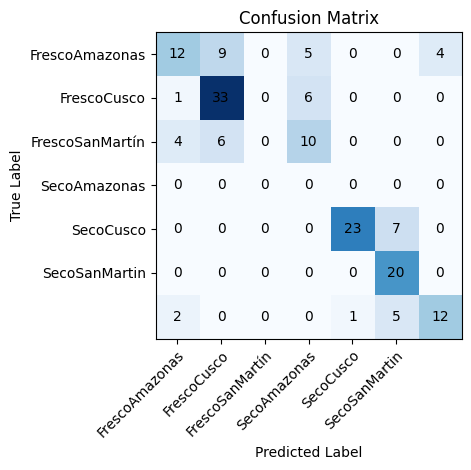

Train
Model: GaussianNB
Accuracy: 0.6875
Recall: 0.7111111111111109
F1-score: 0.7181818181818181


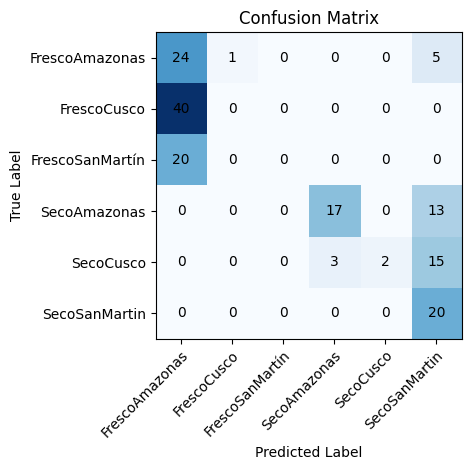

Train
Model: BernoulliNB
Accuracy: 0.375
Recall: 0.3968253968253968
F1-score: 0.34329004329004326


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


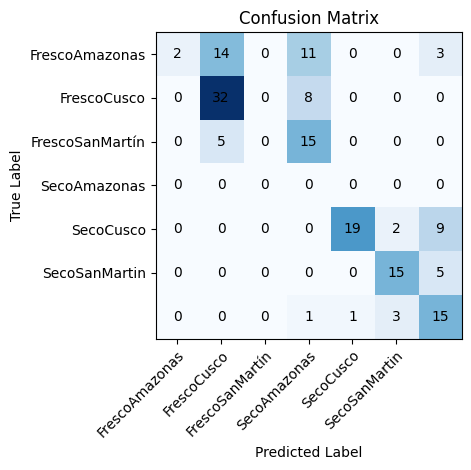

Train
Model: LDA
Accuracy: 0.90625
Recall: 0.9095238095238095
F1-score: 0.9008699633699634


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


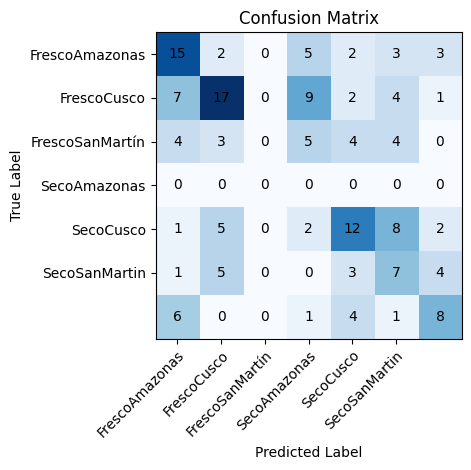

Train
Model: QDA
Accuracy: 0.4375
Recall: 0.4444444444444444
F1-score: 0.45248640248640254


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


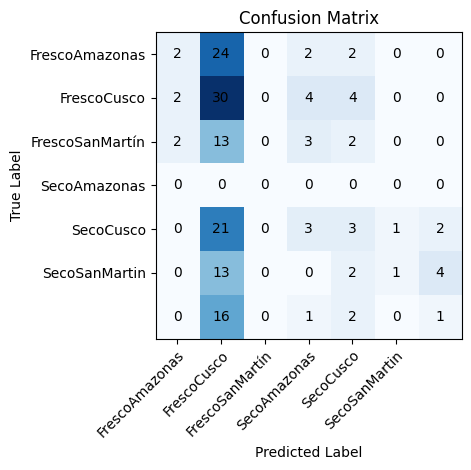

Train
Model: GaussianProcess
Accuracy: 0.78125
Recall: 0.7857142857142857
F1-score: 0.7561447811447812


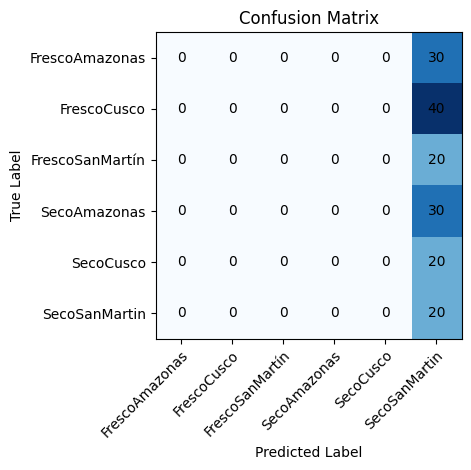

,Model,Group id,Num. common node,Accuracy,Recall,F1-score
8,ExtraTrees,FrescoCusco,110,0.81250,0.657143,0.643910
7,RandomForest,FrescoCusco,110,0.80000,0.647619,0.632877
2,SGDClassifier,FrescoCusco,110,0.78125,0.632143,0.616967
11,GradientBoosting,FrescoCusco,110,0.76250,0.619048,0.606241
3,Perceptron,FrescoCusco,110,0.76250,0.621429,0.603824
15,LinearSVC,FrescoCusco,110,0.74375,0.600000,0.587029
0,LogisticRegression,FrescoCusco,110,0.73750,0.601190,0.586158
5,DecisionTree,FrescoCusco,110,0.73750,0.589286,0.592934
4,PassiveAggressive,FrescoCusco,110,0.71250,0.577381,0.568496
14,NuSVC,FrescoCusco,110,0.70000,0.559524,0.548444


In [54]:
# Iterations
list_metrics = []

for name, model in models_best.items():
    try:
        # Select and train model
        best_model = models[name]
        best_model.fit(X_train, y_train)
        
        # Evaluation
        y_pred = best_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        recall_macro = recall_score(y_test, y_pred, average="macro")
        f1_macro = f1_score(y_test, y_pred, average="macro")

        print("Train")
        print("Model:", name)
        print("Accuracy:", accuracy)
        print("Recall:", recall_macro)
        print("F1-score:", f1_macro)
        
        # Predict on December data
        y_pred_new = best_model.predict(X_test_new)
        # print(len(y_pred_new))
        
        accuracy = accuracy_score(y_test_new, y_pred_new)
        recall_macro = recall_score(y_test_new, y_pred_new, average="macro")
        f1_macro = f1_score(y_test_new, y_pred_new, average="macro")
        
        list_metrics.append([name, group_id, len(common_node_id), accuracy, recall_macro, f1_macro])
        
        """ print("Test")
        print("Model:", name)
        print("Accuracy:", accuracy)
        print("Recall:", recall_macro)
        print("F1-score:", f1_macro) """

        # Plot CM
        cm = confusion_matrix(y_test_new, y_pred_new)
        class_names = best_model.classes_
        tick_marks = np.arange(len(class_names))

        plt.figure()
        plt.imshow(cm, cmap="Blues")
        plt.title("Confusion Matrix")
        # plt.colorbar()
        plt.xticks(tick_marks, class_names, rotation=45, ha="right", rotation_mode="anchor")
        plt.yticks(tick_marks, class_names)

        # Values inside each cell
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(
                    j, i,
                    format(cm[i, j], "d"),
                    ha="center",
                    va="center"
                )

        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()
    except:
        # print(f"Error in {name}")
        pass

df_metrics = pd.DataFrame(list_metrics,  columns=["Model", "Group id", "Num. common node", "Accuracy", "Recall", "F1-score"])
df_metrics.sort_values(by="Accuracy", ascending=False)

Evaluation with December data

In [55]:
""" df_comp = pd.DataFrame({
    "y true": y_test_new,
    "y pred": y_pred_new
})
df_comp.head(50) """

' df_comp = pd.DataFrame({\n    "y true": y_test_new,\n    "y pred": y_pred_new\n})\ndf_comp.head(50) '